In [46]:
import sys
sys.path.insert(0,'..')

In [47]:
import os
import re
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from transformers import AutoTokenizer

from src.model_functions import model_factory

from IPython.display import clear_output

In [48]:
output_folder = "charts"
model_type = "bertbase" # bertl4
folder = f"/share/home/lukash/pan16/{model_type}/cp"
prot_attr = "gender"
par_idx = 0
n_seeds = 5
savefigs = True

f =  folder.split("/")[-1]
if "modular" in f:
    experiment_name = "modular-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-gender_age-seed{}.pt"
elif "cp_init" in f:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-cp_init-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"
else:
    experiment_name = f"adverserial-diff_pruning_0.01-bert-base-uncased-64-2e-05-sp_pen1.25e-07-weighted_loss_prot-{prot_attr}-seed{'{}'}.pt"

# visualization params
if "modular" in f:
    model_cat = "Modular"
elif "cp_init" in f:
    model_cat = "ModularPostHoc"
else:
    model_cat = "DiffPruning"

In [49]:
diff_weights = {}
with torch.no_grad():
    for seed in range(n_seeds):
        exp_name = experiment_name.format(seed)
        filepath = os.path.join(folder, exp_name)
        model = model_factory(filepath)

        dw = model.get_diff_weights(idx=par_idx)
        for k,v in dw:
            try:
                diff_weights[k].append(v)
            except KeyError:
                diff_weights[k] = [v]

diff_weights = {k:torch.stack(v).bool() for k,v in diff_weights.items()}
clear_output()

In [50]:
parameter_sizes = {}
for k,v in diff_weights.items():
    k_ = ".".join(k.split(".")[:-1])
    try:
        parameter_sizes[k_] += v.numel()
    except KeyError:
        parameter_sizes[k_] = v.numel()

parameter_sizes_emb = {".".join(k.split(".")[1:]):v for k,v in parameter_sizes.items() if k[:9] == "embedding"}
parameter_sizes_layer = {".".join(k.split(".")[3:]):v for k,v in parameter_sizes.items() if k[:15] == "encoder.layer.0"}

In [51]:
base_dict = {}
for k,v in diff_weights.items():
    if k[:12] != "pooler.dense":
        k_ = ".".join(k.split(".")[:-1])
        v_ = v.sum(0)
        try:
            base_dict[k_].append(v_)
        except KeyError:
            base_dict[k_] = [v_]

layer_dict = dict(enumerate([[] for x in range(model.total_layers)]))
for k,v in base_dict.items():
    if k.split(".")[0]=="embeddings":
        try:
            layer_dict[0].extend(v)
        except KeyError:
            layer_dict[0] = v
    else:
        layer_id = int(k.split(".")[2])+1
        try:
            layer_dict[layer_id].extend(v)
        except KeyError:
            layer_dict[layer_id] = v

module_dict = {}
for m in [*parameter_sizes_emb.keys(), *parameter_sizes_layer.keys()]:
    for k,v in base_dict.items():
        if (k.split(".")[0]=="embeddings" and m == ".".join(k.split(".")[1:])) or m == ".".join(k.split(".")[3:]):
            try:
                module_dict[m].extend(v)
            except KeyError:
                module_dict[m] = v

layer_list = [dict(zip(parameter_sizes_layer.keys(), [[] for x in range(len(parameter_sizes_layer))])) for _ in range(len(layer_dict)-1)]
for k,v in base_dict.items():
    if k.split(".")[0]!="embeddings":
        layer_id = int(k.split(".")[2])
        m = ".".join(k.split(".")[3:])
        layer_list[layer_id][m].extend(v)

overall = [x for l in base_dict.values() for x in l]  

In [52]:
def calc_homogeneity_fn(v):
    total = sum([x.bool().sum() for x in v])
    cnts = torch.stack([x.view(-1).bincount(minlength=n_seeds+1) for x in v]).sum(0) / total
    return cnts[1:].nan_to_num().tolist()    

for k in list(base_dict.keys()):
    v = base_dict[k]
    base_dict[k] = calc_homogeneity_fn(v)

for k in list(layer_dict.keys()):
    v = layer_dict[k]
    layer_dict[k] = calc_homogeneity_fn(v)

for k in list(module_dict.keys()):
    v = module_dict[k]
    module_dict[k] = calc_homogeneity_fn(v)

for d in layer_list:
    for k in list(d.keys()):
        v = d[k]
        d[k] = calc_homogeneity_fn(v)

overall = calc_homogeneity_fn(overall)

In [53]:
n_layers = len(layer_list)
n_modules = len(layer_list[0])
module_names = list(layer_list[0].keys())

emb_dict = {k[11:]:v for k,v in base_dict.items() if k[:10]=="embeddings"}
emb_n_modules = len(emb_dict)

cmap = plt.get_cmap('Oranges')

# use to change number range for color gradient
color_fn = lambda x: (np.array(x) * np.arange(len(x))).sum() / len(x)

height = 1
width = 2
spacing = 0.5

y_coords = height * np.arange(n_layers) + height/2
y_coords_adj = np.concatenate([
    y_coords,
    [y_coords[-1] + height, y_coords[-1] + height + spacing]]
)

x_coords = width * np.arange(n_modules) + width/2
x_coords_adj = np.concatenate([
    x_coords,
    [x_coords[-1] + width, x_coords[-1] + width + spacing]
])

hline_positions = np.concatenate([
    (y_coords - height/2),
    [y_coords[-1] + height/2, y_coords_adj[-1] - height/2, y_coords_adj[-1] + height/2]
])
vline_positions = [x_coords[0] - width/2, x_coords[-1] + width/2, x_coords_adj[-1] - width/2, x_coords_adj[-1] + width/2]

text_format = "/".join(["{:.2f}"]*n_seeds)

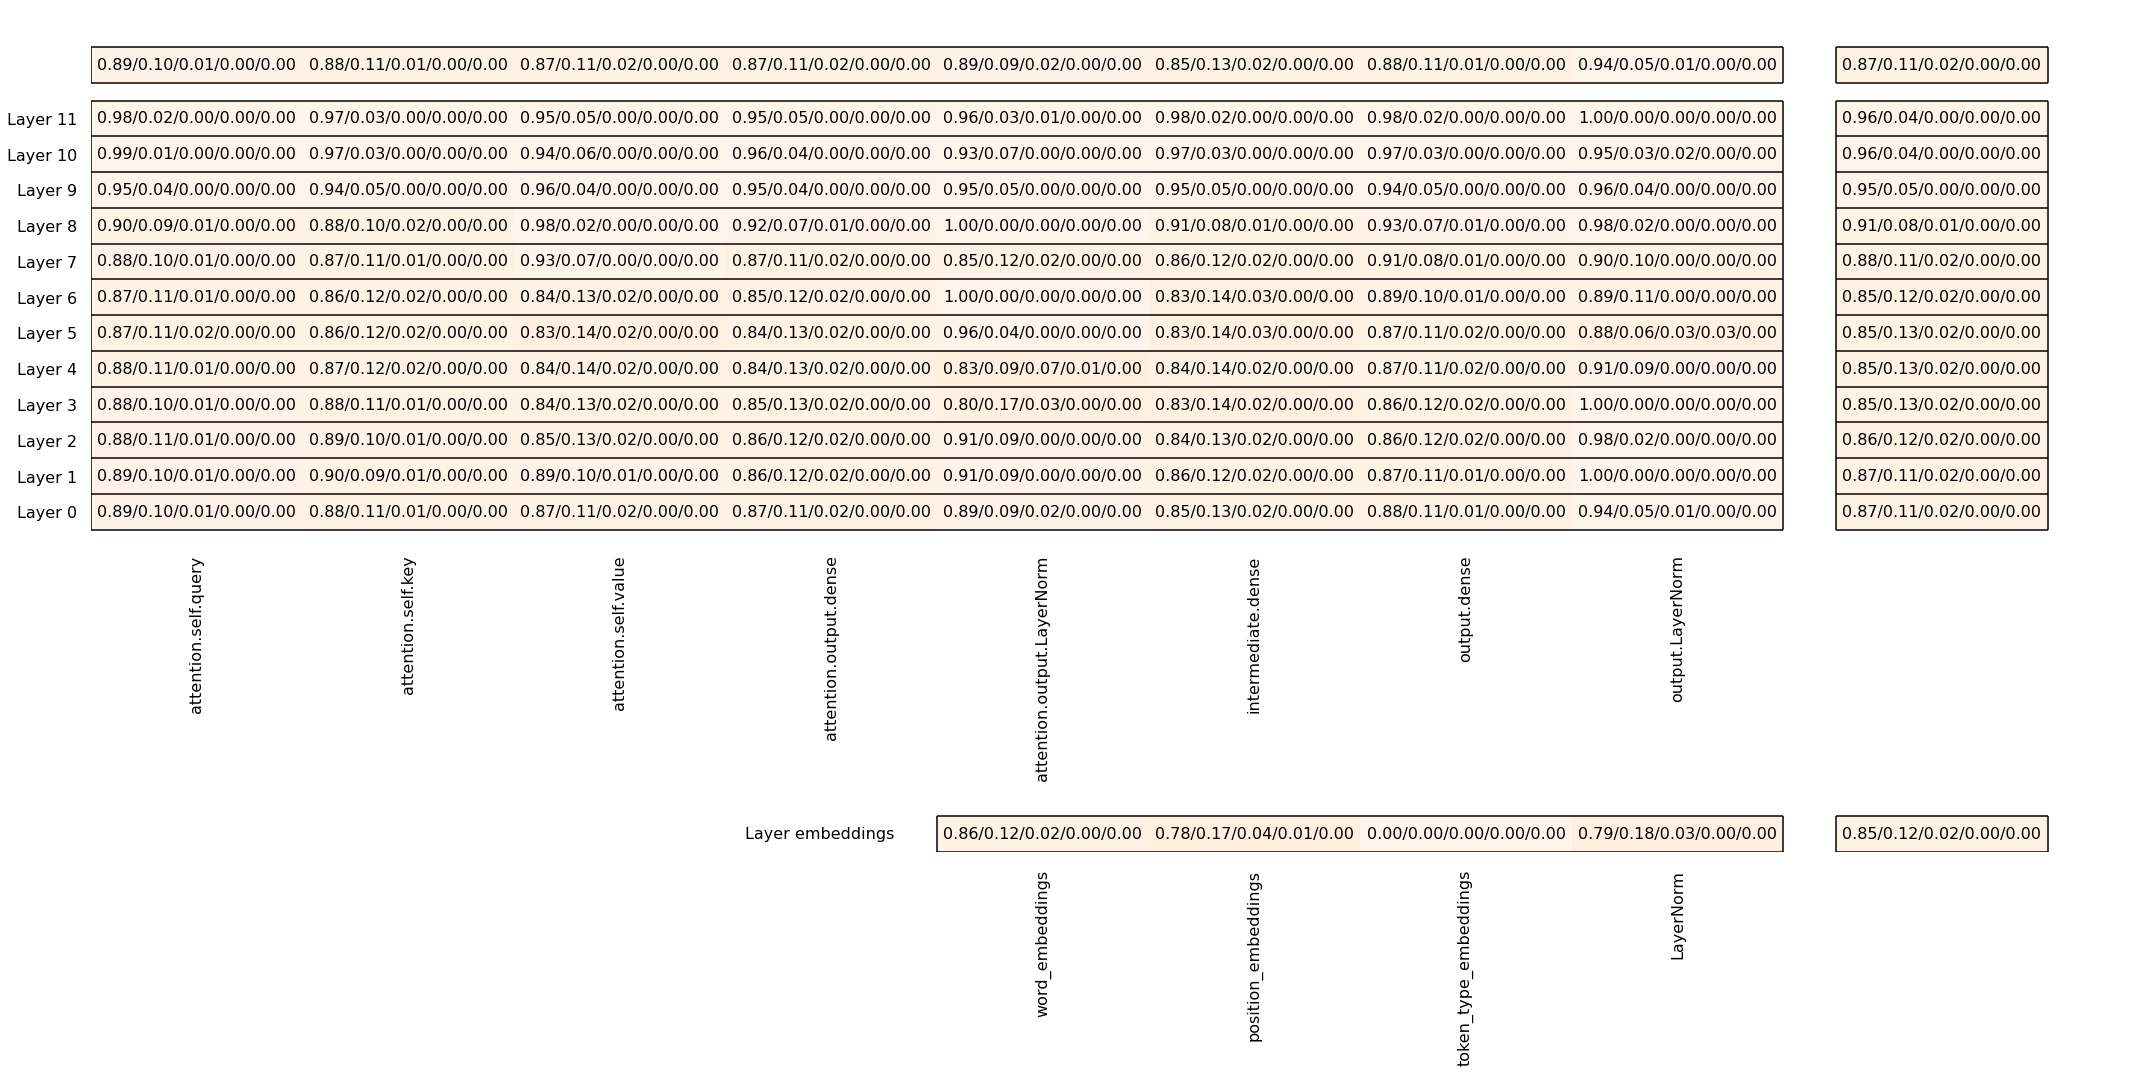

In [54]:
title_fontsize = 16
text_fontsize = 16
title = f"Homogeneity per module - {model_cat} - {prot_attr}"
filename = f"homogeneity_per_module_{model_cat.lower()}_{prot_attr}.png"

plt.figure(figsize=(30,15))
start = 0
for m_name in module_names:
    vals = [l[m_name] for l in layer_list]
    m_val = module_dict[m_name]
    color = [cmap(color_fn(v)) for v in vals]
    color.append("w")
    color.append(cmap(color_fn(m_val)))
    plt.barh(y_coords_adj, width, height=height, left=start, color=color)
    for y, v in zip(y_coords, vals):
        t = text_format.format(*v)
        plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
    t = text_format.format(*m_val)
    plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)
    start += width

start += spacing

vals = list(layer_dict.values())[1:]
color = [cmap(color_fn(v)) for v in vals]
color.append("w")
color.append(cmap(color_fn(overall)))
plt.barh(y_coords_adj, width, height=height, left=start, color=color)
for y, v in zip(y_coords, vals):
    t = text_format.format(*v)
    plt.text(start+width/2, y, t, ha='center', va='center', color="k", fontsize=text_fontsize)
t = text_format.format(*overall)
plt.text(start+width/2, y_coords_adj[-1], t, ha='center', va='center', color="k", fontsize=text_fontsize)

for y in hline_positions:
    plt.hlines(y, 0, width*n_modules, colors="black")
for y in hline_positions:#[:-2]:
    plt.hlines(y, width*n_modules+spacing, width*(n_modules+1)+spacing, colors="black")

for x in vline_positions:
    plt.vlines(x, 0, y_coords[-1]+height/2, colors="black")
for x in vline_positions:#[:2]:
    plt.vlines(x, y_coords_adj[-1]-height/2, y_coords_adj[-1]+height/2, colors="black")

# embedding layer
assert n_modules >= emb_n_modules, "'x_coords_adj' is created based on n_modules and assumes emb_n_modules <= n_modules"

y_pos = -9
vals = list(emb_dict.values())
l_val = layer_dict[0]
color = [cmap(color_fn(v)) for v in vals] + ["w", cmap(color_fn(l_val))]
plt.bar(x_coords_adj[-(emb_n_modules+2):], height=height, width=[width] * emb_n_modules + [spacing, width], bottom=y_pos, color=color)
for x, v in zip(x_coords[-emb_n_modules:], vals):
    t = text_format.format(*v)
    plt.text(x, y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)
t = text_format.format(*l_val)
plt.text(x_coords_adj[-1], y_pos + height/2, t, ha='center', va='center', color="k", fontsize=text_fontsize)

x_coords_lines = [x_coords[-emb_n_modules]-width/2, [x_coords[-1]+width/2], x_coords_adj[-1]-width/2, x_coords_adj[-1]+width/2]
y_coords_lines = [y_pos, y_pos+height]
for y in y_coords_lines:
    plt.hlines(y, x_coords_lines[0], x_coords_lines[1], colors="black")
    plt.hlines(y, x_coords_lines[2], x_coords_lines[3], colors="black")
for x in x_coords_lines:
    plt.vlines(x, y_coords_lines[0], y_coords_lines[1], colors="black")

# embedding ticks
xtick_offset = -1.4
ytick_offset = 0.5
for x, t in zip(x_coords[-emb_n_modules:], emb_dict.keys()):
    plt.text(x, y_pos - height/2, t, ha='center', va='top', rotation=90, fontsize=text_fontsize)
plt.text(x_coords[-emb_n_modules] + xtick_offset, y_pos + ytick_offset, "Layer embeddings", ha='right', va='center', fontsize=text_fontsize)

plt.xticks(np.arange(width*n_modules, step=width) + width/2, labels=module_names, rotation=90, fontsize=text_fontsize)
plt.yticks(y_coords, labels=[f"Layer {i}" for i in range(n_layers)], fontsize=text_fontsize)
# plt.title(title, fontsize=title_fontsize, y=.98)
sns.despine(left=True, bottom=True, right=True)
plt.tick_params(axis="x", bottom=False, pad=-300)
plt.tick_params(axis="y", left=False, pad=10)

plt.tight_layout()
if savefigs:
    plt.savefig(os.path.join(output_folder, filename))
plt.show()